# Introduction 
Zyfra, a leader in efficiency-boosting solutions for the heavy industry sector, has initiated a project to create a predictive machine learning model for gold recovery from gold ore. The key objective of this model is to refine production processes and phase out unprofitable parameters, effectively maximizing overall efficiency.  

To reach this goal, the project encompasses the following stages:  

**Data Preparation**: Amass and preprocess pertinent data on gold extraction and refinement.  

**Data Analysis**: Implement comprehensive data analysis to uncover crucial patterns and insights.  

**Model Development and Training**: Design and educate a machine learning model for precise gold recovery prediction.  

The strategy relies on sophisticated machine learning methodologies to yield practical insights, thus leading to improved decision-making and operational enhancements in gold recovery processes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


In [2]:
gold_train = pd.read_csv('datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('datasets/gold_recovery_test.csv') 
gold_full = pd.read_csv('datasets/gold_recovery_full.csv')

In [25]:
print(gold_train.shape)
print(gold_test.shape)
print(gold_full.shape)

(16860, 87)
(5856, 53)
(22716, 87)


In [26]:
print(f"Duplicated values in gold_train: {gold_train.duplicated().sum()} ")
print(f"Duplicated values in gold_test: {gold_test.duplicated().sum()} ")
print(f"Duplicated values in gold_full: {gold_full.duplicated().sum()} ")

Duplicated values in gold_train: 0 
Duplicated values in gold_test: 0 
Duplicated values in gold_full: 0 


In [27]:
print(f"Missing values in gold_train:\n{gold_train.isna().sum()}\n")
print(f"Missing values in gold_test:\n{gold_test.isna().sum()}\n")
print(f"Missing values in gold_full:\n{gold_full.isna().sum()}\n")


Missing values in gold_train:
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

Missing values in gold_test:
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner

In [28]:
def calc_recovery(data, calc_type="rougher"):
    '''Returns the input dataframe with a {calc_type}.calculated.recovery column for either the rougher or final yield (default is 'rougher') and a Pandas series containing the recovery values.
    Recovery is calculated using the following equation: ((C * (F-T)) / (F * (C-T))) * 100. '''
    
    C = data[f'{calc_type}.output.concentrate_au']
    T = data[f'{calc_type}.output.tail_au']
    F = data['rougher.input.feed_au'] if calc_type == "rougher" else data['rougher.output.concentrate_au']
    
    recovery = ((C * (F-T)) / (F * (C-T))) * 100
    
    print(f"Calculated Recovery for '{calc_type}' \n{recovery}")
    
    # Add recovery to dataframe
    data[f'{calc_type}.calculated.recovery'] = recovery
    
    # Replace infinity values with NaN (if needed)
    data[f'{calc_type}.calculated.recovery'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return data, recovery

In [29]:
# Calcuate rougher recovery for gold_train
gold_train, predicted_recovery_values = calc_recovery(gold_train.dropna(subset=['rougher.output.recovery']), calc_type="rougher")

#Grab values for actual recovery
actual_recovery_values = gold_train['rougher.output.recovery']

print(f"Actual Recovery for 'rougher':\n{actual_recovery_values}")


Calculated Recovery for 'rougher' 
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14287, dtype: float64
Actual Recovery for 'rougher':
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14287, dtype: float64


/tmp/ipykernel_32/211960037.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{calc_type}.calculated.recovery'] = recovery
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [30]:
print(actual_recovery_values.isna().sum())
print(predicted_recovery_values.isna().sum())

0
0


In [31]:
valid_indices = ~predicted_recovery_values.isin([np.nan, np.inf, -np.inf])
actual_recovery_values = actual_recovery_values[valid_indices]
predicted_recovery_values = predicted_recovery_values[valid_indices]

#Calculate MAE between actual and calculated recovery values
mae = mean_absolute_error(actual_recovery_values, predicted_recovery_values)

print(f"Mean Absolute Error (MAE) between actual and calculated recovery values: {mae}")

Mean Absolute Error (MAE) between actual and calculated recovery values: 9.303415616264301e-15


<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct

</div>

In [32]:
gold_train.fillna(method='ffill', inplace=True)
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14287 non-null  object 
 1   final.output.concentrate_ag                         14287 non-null  float64
 2   final.output.concentrate_pb                         14287 non-null  float64
 3   final.output.concentrate_sol                        14287 non-null  float64
 4   final.output.concentrate_au                         14287 non-null  float64
 5   final.output.recovery                               14287 non-null  float64
 6   final.output.tail_ag                                14287 non-null  float64
 7   final.output.tail_pb                                14287 non-null  float64
 8   final.output.tail_sol                               14287 non-null  float64


In [33]:
gold_test.fillna(method='ffill', inplace=True)
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job

</div>

In [34]:
#finding the missing columns
missing_columns = set(gold_train.columns) - set(gold_test.columns)

# Convert the set to a list for easier processing
missing_list = list(missing_columns)

# Get the data types of the missing columns
missing_columns_types = gold_train[missing_list].dtypes

# Display the types of the missing columns
print(missing_columns_types)


# Calculate the mean of missing values in each column
missing_values_mean = gold_full.isnull().mean()

# Print the result
print(missing_values_mean)

rougher.output.concentrate_sol                        float64
final.output.tail_ag                                  float64
primary_cleaner.output.tail_pb                        float64
rougher.output.concentrate_ag                         float64
primary_cleaner.output.concentrate_au                 float64
final.output.concentrate_pb                           float64
final.output.concentrate_au                           float64
primary_cleaner.output.concentrate_sol                float64
final.output.tail_pb                                  float64
rougher.calculated.recovery                           float64
rougher.output.tail_pb                                float64
rougher.calculation.sulfate_to_au_concentrate         float64
secondary_cleaner.output.tail_sol                     float64
rougher.calculation.floatbank11_sulfate_to_au_feed    float64
rougher.calculation.au_pb_ratio                       float64
final.output.tail_au                                  float64
primary_

---

<div class="alert alert-success">
<b>Reviewer's comment</b>

Correct

</div>

# 2 Analyze Data

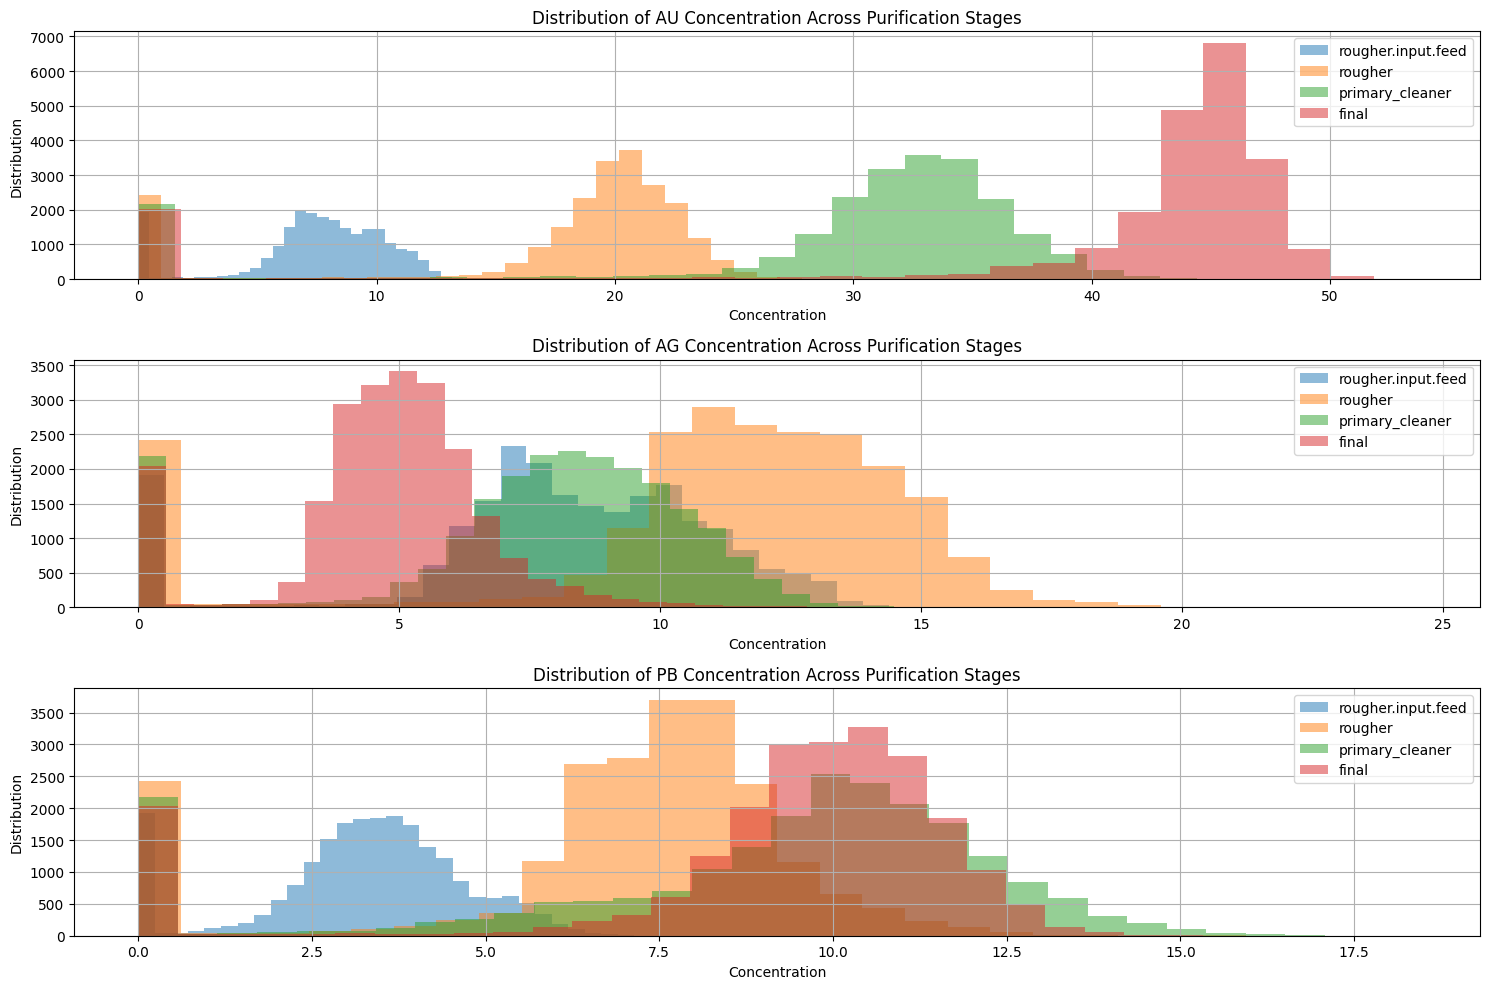

In [35]:
stages = ['rougher.input.feed', 'rougher', 'primary_cleaner', 'final']
metals = ['au', 'ag', 'pb']

# Plot histograms for each metal
plt.figure(figsize=(15, 10))

for i, metal in enumerate(metals, 1):
    plt.subplot(3, 1, i)
    for stage in stages:
        column_name = f'{stage}.output.concentrate_{metal}' if stage != 'rougher.input.feed' else f'{stage}_{metal}'
        plt.hist(gold_full[column_name], bins=30, alpha=0.5, label=stage)
    plt.title(f'Distribution of {metal.upper()} Concentration Across Purification Stages')
    plt.xlabel('Concentration')
    plt.ylabel('Distribution')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Concentration of Gold (Au)**  

Rougher Input Feed: Gold possesses a notably high initial concentration, exhibited in a wide-ranging distribution.  

Rougher: A minor decrease in gold concentration follows the rougher phase, hinting at some level of purification.  

Primary Cleaner: The gold concentration reduction continues, implying additional purification.  

Final: The concluding stage showcases the minimal gold concentration, which signals the utmost purification.  

**Silver (Ag) Concentration Levels**  

Rougher Input Feed: Silver begins with a high concentration that is distributed widely.  

Rougher: A marked decrease in concentration is observed post the rougher stage.  

Primary Cleaner: The concentration sustains the downward trajectory, demonstrating an effective purification.  

Final: The ultimate stage exhibits the least silver concentration, thus signifying a successful purification.  

**Lead (Pb) Concentration Levels**  

Rougher Input Feed: Lead concentration starts off high, dispersed over a wide distribution.  

Rougher: The concentration diminishes following the rougher stage.  

Primary Cleaner: The concentration goes on decreasing, indicating a further purification.  

Final: The last stage reveals the smallest concentration of lead, denoting effective purification.  

General Remarks
Purification Efficacy: Each purification stage notably diminishes the concentration of metals (Au, Ag, Pb). The concluding stage persistently reveals the lowest concentrations, symbolizing the highest purification level.
Distribution Patterns: The concentration distribution of metals narrows down and veers towards lesser values as the purification stages advance. This suggests that the process not only lessens the average concentration but also standardizes the distribution.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Well done!

</div>

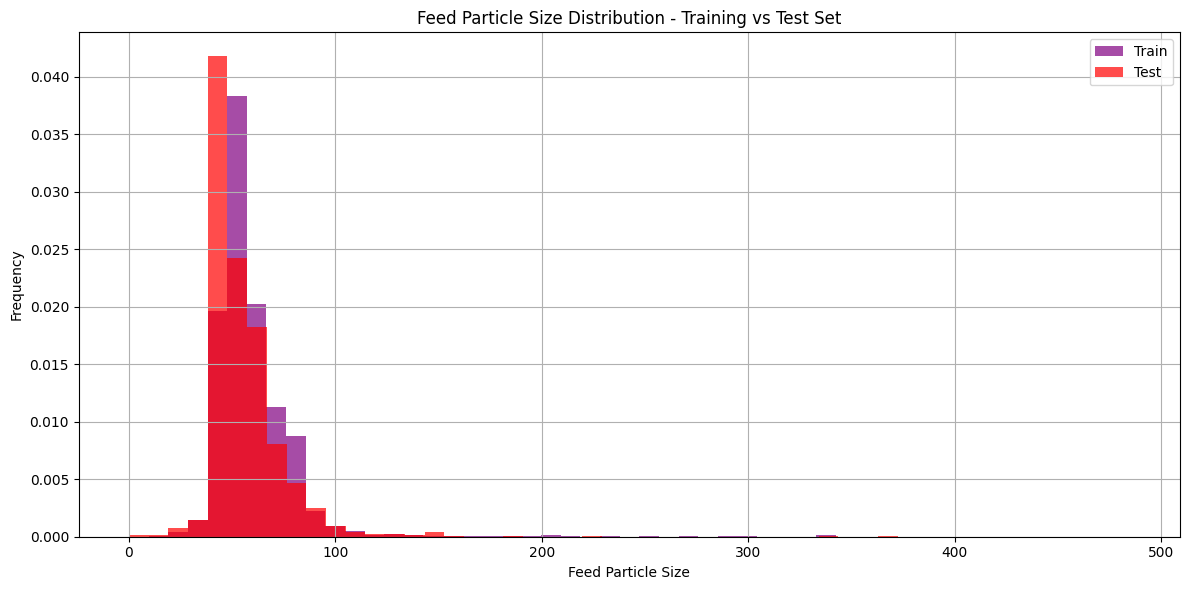

Training Set Feed Particle Size Summary:
count    14287.000000
mean        60.179089
std         22.985089
min          9.659576
25%         48.932377
50%         55.251872
75%         65.976914
max        484.967466
Name: rougher.input.feed_size, dtype: float64
Test Set Feed Particle Size Summary:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64


In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Overlay normalized histograms for training and test sets
plt.hist(gold_train['rougher.input.feed_size'], bins=50, alpha=0.7, label='Train', color='purple',density=True)
plt.hist(gold_test['rougher.input.feed_size'], bins=50, alpha=0.7, label='Test', color='red',density=True)

plt.title('Feed Particle Size Distribution - Training vs Test Set')
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

train_summary = gold_train['rougher.input.feed_size'].describe()
test_summary = gold_test['rougher.input.feed_size'].describe()

print(f"Training Set Feed Particle Size Summary:\n{train_summary}")
print(f"Test Set Feed Particle Size Summary:\n{test_summary}")


It's important to note the substantial variation in feed particle size distributions seen when comparing the training set to the test set:  

**Training Set**: This set demonstrates a pronounced presence of smaller particle sizes, but this presence quickly dwindles as the particle size grows.  
**Test Set**: Starting off, this set depicts a less numerous occurrence of minute sizes than in the training set and shows a more gradual decrease.  
These variations hint at a potential misalignment between the training and test sets concerning feed particle size distribution. This misalignment could influence the performance of the model.  

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Correct, but:
    
1. When you need to compare distributions with different number of observations you need to plot normalized histograms to avoid dependence on the number of observations. So, please, fix it.
2. For ML models it's okay when distributions are not 100% the same. It's enough that they are just similar.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Good job! As you can see these distributions are really similar and so it shouldn't be a problem for any ML model

</div>

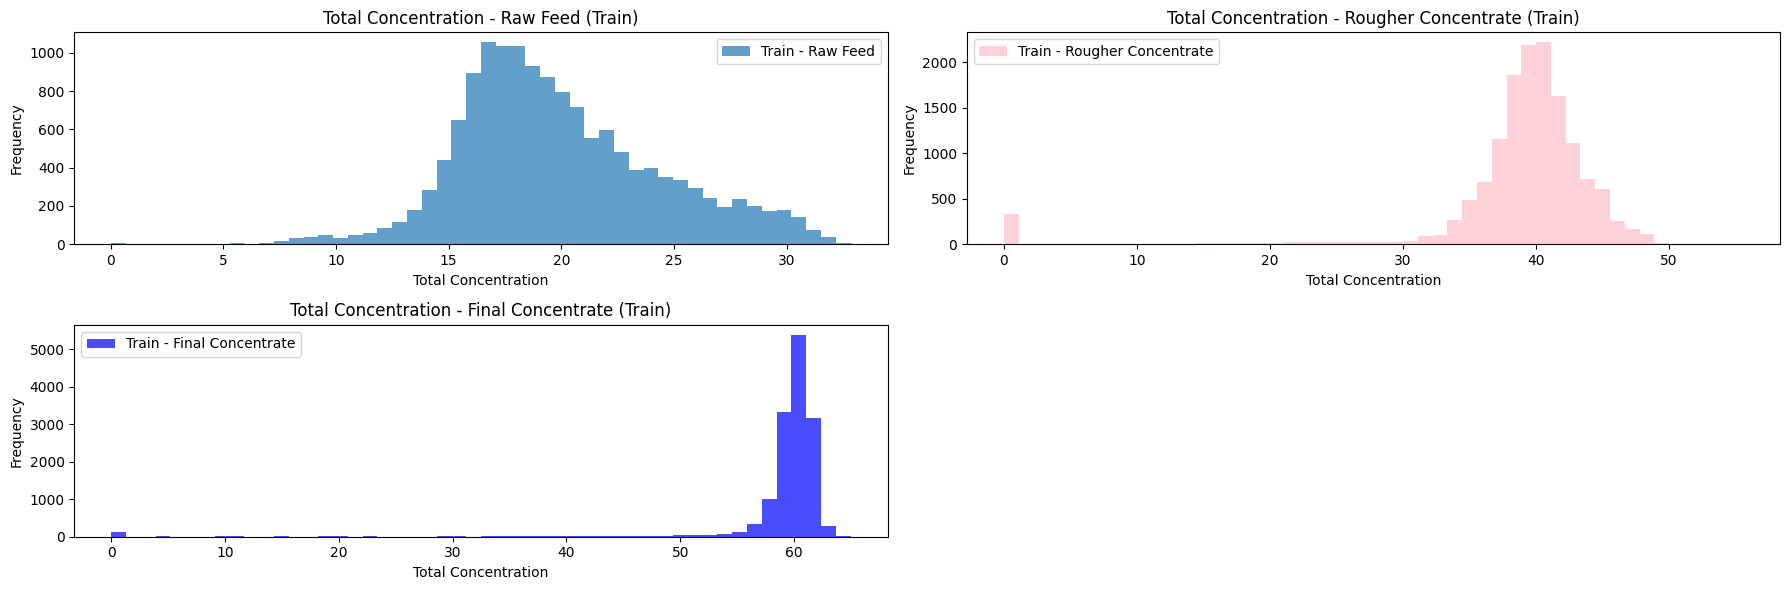

In [37]:
# Calculating total concentrations for training 
gold_train['total_concentration_raw_feed'] = gold_train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_train['total_concentration_rougher'] = gold_train[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
gold_train['total_concentration_final'] = gold_train[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Plotting the concentrations
plt.figure(figsize=(18, 6))

# Training set
plt.subplot(2, 2, 1)
plt.hist(gold_train['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Train - Raw Feed')
plt.title('Total Concentration - Raw Feed (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gold_train['total_concentration_rougher'], bins=50, alpha=0.7, label='Train - Rougher Concentrate', color='pink')
plt.title('Total Concentration - Rougher Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(gold_train['total_concentration_final'], bins=50, alpha=0.7, label='Train - Final Concentrate', color='blue')
plt.title('Total Concentration - Final Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

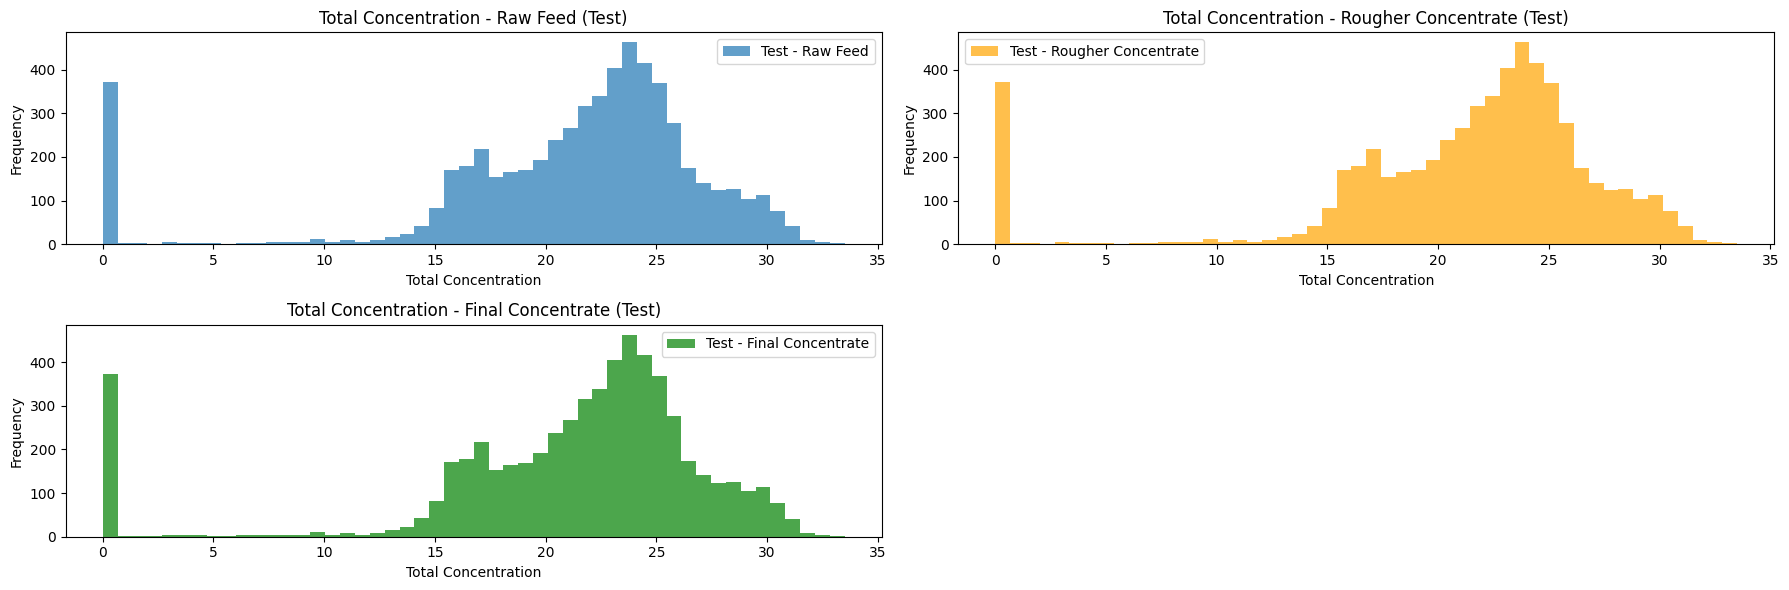

In [38]:
# Calculating concentrations for test set
gold_test['total_concentration_raw_feed'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_test['total_concentration_rougher'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_test['total_concentration_final'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

# Plotting total concentrations
plt.figure(figsize=(18, 6))

# Test set
plt.subplot(2, 2, 1)
plt.hist(gold_test['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Test - Raw Feed')
plt.title('Total Concentration - Raw Feed (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gold_test['total_concentration_rougher'], bins=50, alpha=0.7, label='Test - Rougher Concentrate', color='orange')
plt.title('Total Concentration - Rougher Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(gold_test['total_concentration_final'], bins=50, alpha=0.7, label='Test - Final Concentrate', color='green')
plt.title('Total Concentration - Final Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
gold_train['total_concentration_raw_feed'] = gold_train[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_train['total_concentration_rougher'] = gold_train[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
gold_train['total_concentration_final'] = gold_train[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

# Calculate total concentrations at each stage for test set
gold_test['total_concentration_raw_feed'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_test['total_concentration_rougher'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
gold_test['total_concentration_final'] = gold_test[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)

# Remove rows with zero concentration values
gold_train = gold_train[(gold_train['total_concentration_raw_feed'] > 0) | 
                    (gold_train['total_concentration_rougher'] > 0) | 
                    (gold_train['total_concentration_final'] > 0)]

gold_test = gold_test[(gold_test['total_concentration_raw_feed'] > 0) | 
                  (gold_test['total_concentration_rougher'] > 0) | 
                  (gold_test['total_concentration_final'] > 0)]



In [40]:
print(gold_train.shape)
print(gold_test.shape)

(14287, 91)
(5485, 56)


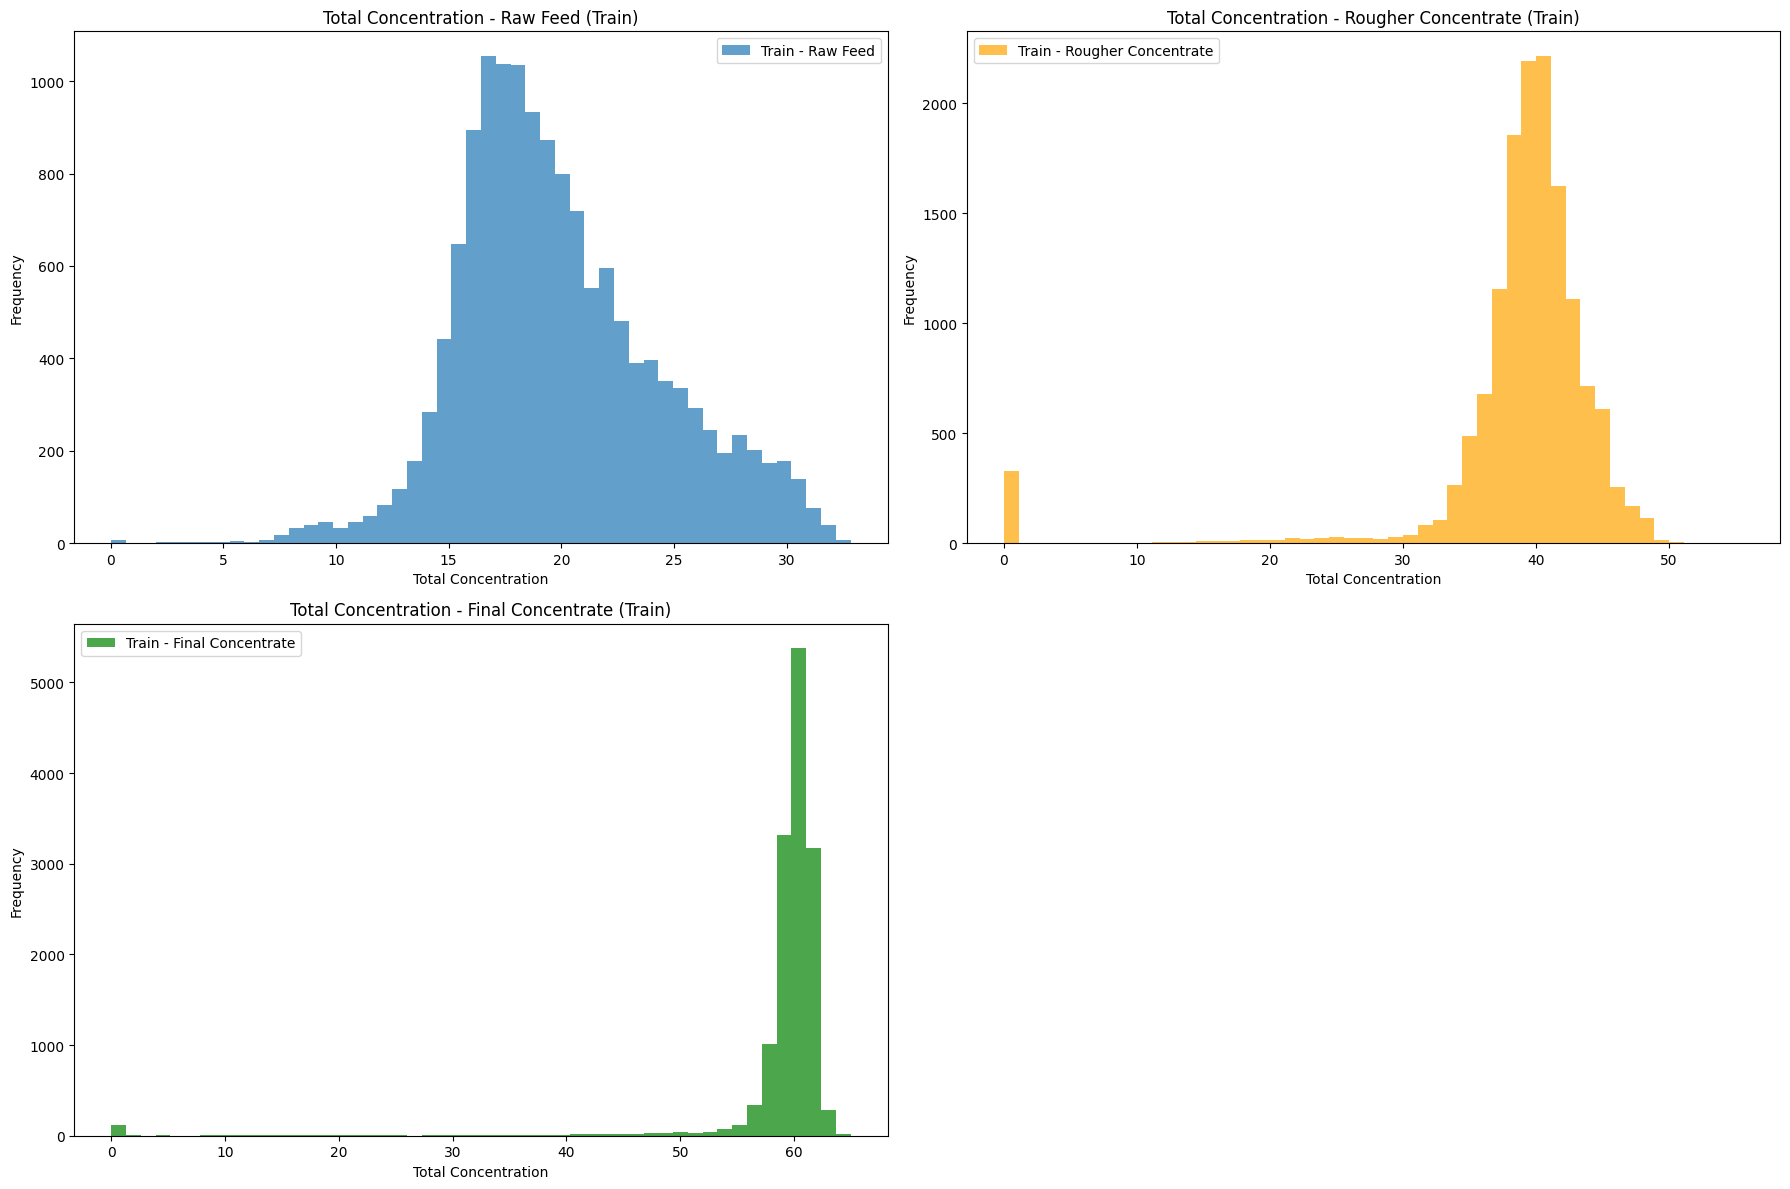

In [41]:
plt.figure(figsize=(18, 12))

# Training set
plt.subplot(2, 2, 1)
plt.hist(gold_train['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Train - Raw Feed')
plt.title('Total Concentration - Raw Feed (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gold_train['total_concentration_rougher'], bins=50, alpha=0.7, label='Train - Rougher Concentrate', color='orange')
plt.title('Total Concentration - Rougher Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(gold_train['total_concentration_final'], bins=50, alpha=0.7, label='Train - Final Concentrate', color='green')
plt.title('Total Concentration - Final Concentrate (Train)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

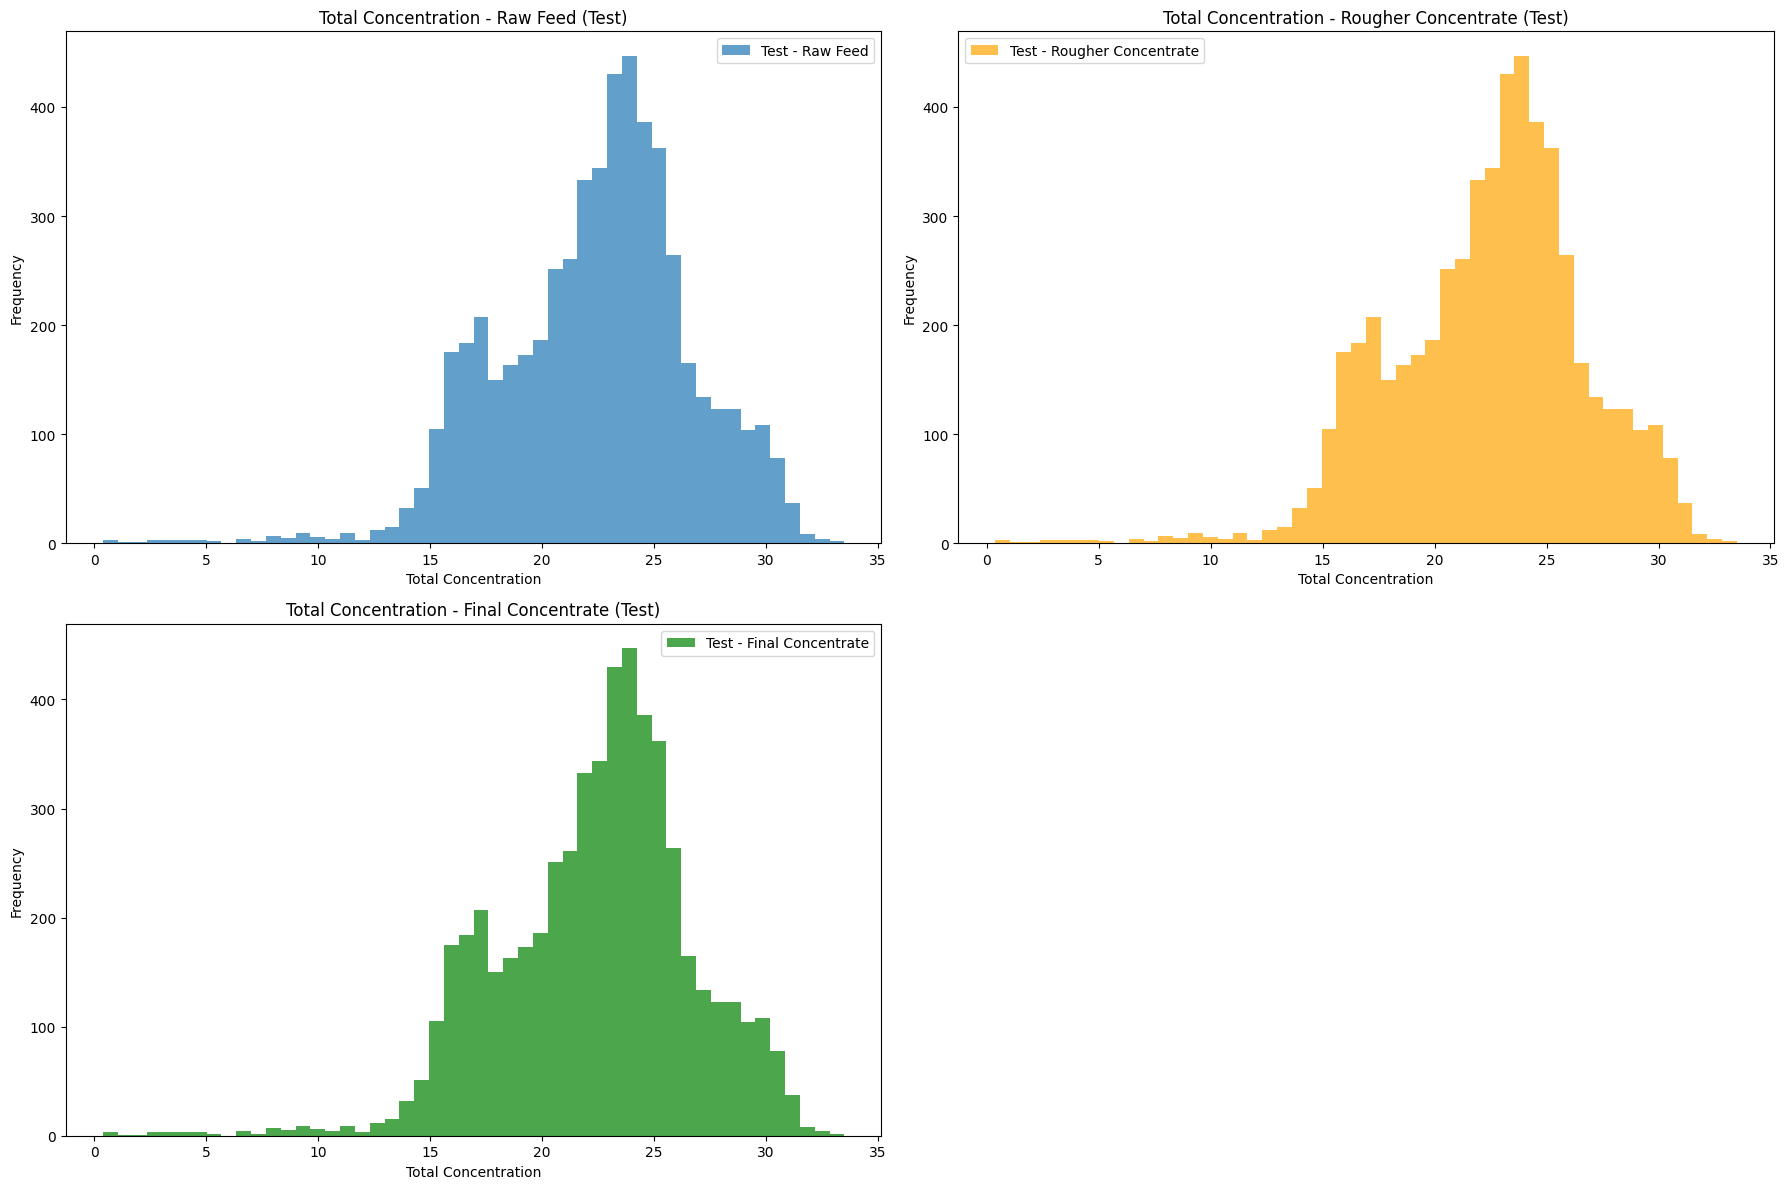

In [42]:
plt.figure(figsize=(18, 12))

# Test set
plt.subplot(2, 2, 1)
plt.hist(gold_test['total_concentration_raw_feed'], bins=50, alpha=0.7, label='Test - Raw Feed')
plt.title('Total Concentration - Raw Feed (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(gold_test['total_concentration_rougher'], bins=50, alpha=0.7, label='Test - Rougher Concentrate', color='orange')
plt.title('Total Concentration - Rougher Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(gold_test['total_concentration_final'], bins=50, alpha=0.7, label='Test - Final Concentrate', color='green')
plt.title('Total Concentration - Final Concentrate (Test)')
plt.xlabel('Total Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Good job! But I would change & to | in you filter condition because it's not okay to have total zero concentration at any single stage and not only on all stages at once.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Correct
</div>

# 3 Build the Model

In [43]:
def preprocess_df(df):
    # Convert the 'date' column to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Extract year, month, day, and hour as new features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour

    # Convert 'date' to timestamp and then to float32
    df['date'] = df['date'].astype(np.int64) / 10**9  # Convert to seconds
    df['date'] = df['date'].astype('float32')

    return df

In [51]:
def smape(target, pred):
    N = len(target)
    smape_value = (1 / N) * np.sum(2 * np.abs(pred - target) / (np.abs(target) + np.abs(pred)))
    return smape_value

def fsmape(target, pred):
    if isinstance(target, pd.DataFrame) or isinstance(target, pd.Series):
        target = target.values
    if isinstance(pred, pd.DataFrame) or isinstance(pred, pd.Series):
        pred = pred.values
    if target.ndim == 1:
        target = target.reshape(-1, 2)
    if pred.ndim == 1:
        pred = pred.reshape(-1, 2)
    rougher_smape = smape(target[:, 0], pred[:, 0])
    final_smape = smape(target[:, 1], pred[:, 1])
    fsmape_value = (0.25 * rougher_smape) + (0.75 * final_smape)
    return fsmape_value

# Create sMAPE scorer
smape_scorer = make_scorer(smape, greater_is_better=False)


In [44]:
gold_train = preprocess_df(gold_train)
gold_test = preprocess_df(gold_test)
gold_full = preprocess_df(gold_full)

In [45]:
# Replace positive and negative infinity with a large finite number
gold_train = gold_train.replace([np.inf, -np.inf], np.finfo('float32').max)
gold_test = gold_test.replace([np.inf, -np.inf], np.finfo('float32').max)
gold_full = gold_full.replace([np.inf, -np.inf], np.finfo('float32').max)

In [46]:
# Convert all columns to float32
gold_train = gold_train.astype('float64')
gold_test = gold_test.astype('float64')
gold_full = gold_full.astype('float64')

# Identify the features present in the test set but not in the training set
train_features = set(gold_train.columns)
test_features = set(gold_test.columns)
features_to_remove = train_features - test_features

# Drop these features from the training set
gold_train = gold_train.drop(columns=[col for col in features_to_remove if col in gold_train.columns])

In [60]:
gold_full.fillna(method='ffill',inplace=True)

In [61]:
gold_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank6_a_level    0
year                                          0
month                                         0
day                                           0
hour                                          0
Length: 91, dtype: int64

In [62]:
gold_full_test = gold_test.merge(gold_full, on='date', how='left')

features_test = gold_full_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) 

# Make sure to only include the target columns here
target_test = gold_full_test[['rougher.output.recovery', 'final.output.recovery']]


gold_full_train = gold_train.merge(gold_full, on='date', how='left')
features = gold_full_train.drop(columns=['rougher.output.recovery', 'final.output.recovery']) 
target = gold_full_train[['rougher.output.recovery', 'final.output.recovery']]  

# Split the data into training and validation sets
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=42)


In [63]:
# Identify columns present in one dataframe but not the other
train_columns = set(features_train.columns)
test_columns = set(features_test.columns)

# Columns to add to features_train
columns_to_add = test_columns - train_columns
# Columns to remove from features_test
columns_to_remove = train_columns - test_columns

# Add missing columns to features_train with default value 
for column in columns_to_add:
    features_train.loc[:, column] = 1

# Remove extra columns from features_test if they exist
features_test = features_test.drop(columns=[col for col in columns_to_remove if col in features_test.columns])

# Ensure the columns are in the same order
features_train = features_train[features_test.columns]

print("Shape of features_train:", features_train.shape)
print("Shape of features_test:", features_test.shape)

Shape of features_train: (11429, 148)
Shape of features_test: (5485, 148)


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Correct. But you filled NaNs previously with better method than to fill NaNs with mean values. So, what is the purpose to try to fill NaNs here again?
   
</div>

<div class="alert alert-danger">
<b>Reviewer's comment</b>

To merge test and full data you can use only column 'date'.

</div>

In [64]:
# Initialize models
regression_rough = DecisionTreeRegressor(random_state=54321)
regression_final = DecisionTreeRegressor(random_state=54321)

# Perform cross-validation and calculate mean sMAPE scores
scores_rougher = cross_val_score(regression_rough, features_train, target_train['rougher.output.recovery'], cv=5, scoring=smape_scorer)
scores_final = cross_val_score(regression_final, features_train, target_train['final.output.recovery'], cv=5, scoring=smape_scorer)

print(f"Average Rougher sMAPE: {np.mean(scores_rougher):.2f}%")
print(f"Average Final sMAPE: {np.mean(scores_final):.2f}%")

# Hyperparameter tuning for DecisionTreeRegressor
param_grid = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
grid_search_rough = GridSearchCV(regression_rough, param_grid, cv=5, scoring=smape_scorer)
grid_search_final = GridSearchCV(regression_final, param_grid, cv=5, scoring=smape_scorer)

grid_search_rough.fit(features_train, target_train['rougher.output.recovery'])
grid_search_final.fit(features_train, target_train['final.output.recovery'])

best_rough = grid_search_rough.best_estimator_
best_final = grid_search_final.best_estimator_

print(f"Best Rougher Model: {grid_search_rough.best_params_}")
print(f"Best Final Model: {grid_search_final.best_params_}")

# Fit the models
best_rough.fit(features_train, target_train['rougher.output.recovery'])
best_final.fit(features_train, target_train['final.output.recovery'])

# Perform cross-validation and calculate mean sMAPE scores for the best models
best_scores_rougher = cross_val_score(best_rough, features_train, target_train['rougher.output.recovery'], cv=5, scoring=smape_scorer)
best_scores_final = cross_val_score(best_final, features_train, target_train['final.output.recovery'], cv=5, scoring=smape_scorer)

print(f"Average Best Rougher sMAPE: {np.mean(best_scores_rougher):.2f}%")
print(f"Average Best Final sMAPE: {np.mean(best_scores_final):.2f}%")

Average Rougher sMAPE: -0.01%
Average Final sMAPE: -0.03%
Best Rougher Model: {'max_depth': 10, 'min_samples_split': 10}
Best Final Model: {'max_depth': 10, 'min_samples_split': 5}
Average Best Rougher sMAPE: -0.02%
Average Best Final sMAPE: -0.04%


<div class="alert alert-danger">
<b>Reviewer's comment</b>

You can't use these features which are not represented in the initial test data in ML models because these features won't be available in production. In other words, in ML models you can use only the featureas which are represented in the initial test data. Other features should be removed from train data.

</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>

Initial test data has only 53 columns. But you test data has 148 columns. So, you have a lot of columns which can not be used in ML models.
    
"You can't use these features which are not represented in the initial test data in ML models because these features won't be available in production. In other words, in ML models you can use only the featureas which are represented in the initial test data. Other features should be removed from train data."
    
From the full data you can take only targets for test data and nothing else.


</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>

You shouldn't have the part "# Add missing columns to features_train with default value " because if you have such columns in means you did something wrong. 

</div>

In [65]:

# Convert datetime columns to numerical features
def convert_datetime(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
                df[col + '_year'] = df[col].dt.year
                df[col + '_month'] = df[col].dt.month
                df[col + '_day'] = df[col].dt.day
                df[col + '_hour'] = df[col].dt.hour
                df.drop(columns=[col], inplace=True)
            except ValueError:
                continue
    return df

# Apply the conversion to both training and test sets
features_train = convert_datetime(features_train)
features_test = convert_datetime(features_test)

# Ensure both datasets have the same columns
common_columns = features_train.columns.intersection(features_test.columns)
features_train = features_train[common_columns]
features_test = features_test[common_columns]

# Scaling numerical features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Initialize linear regression models
lr_regression_rougher = LinearRegression()
lr_regression_final = LinearRegression()

# Perform cross-validation and calculate mean sMAPE scores
lr_scores_rougher = cross_val_score(lr_regression_rougher, features_train_scaled, target_train['rougher.output.recovery'], cv=5, scoring=smape_scorer)
lr_scores_final = cross_val_score(lr_regression_final, features_train_scaled, target_train['final.output.recovery'], cv=5, scoring=smape_scorer)

print(f"Average LR Rougher sMAPE: {np.mean(lr_scores_rougher):.2f}%")
print(f"Average LR Final sMAPE: {np.mean(lr_scores_final):.2f}%")

# Fit the linear regression models
lr_regression_rougher.fit(features_train_scaled, target_train['rougher.output.recovery'])
lr_regression_final.fit(features_train_scaled, target_train['final.output.recovery'])

# Ensure there are no NaN or infinite values in the features_test and target_test
features_test_scaled = pd.DataFrame(features_test_scaled).replace([np.inf, -np.inf], np.nan).dropna()
target_test = target_test.replace([np.inf, -np.inf], np.nan).dropna()

# Ensure features_test and target_test have the same number of rows
min_length = min(features_test_scaled.shape[0], target_test.shape[0])
features_test_scaled = features_test_scaled[:min_length]
target_test = target_test[:min_length]

# Predictions using the Linear Regression models
pred_rougher_test_lr = lr_regression_rougher.predict(features_test_scaled)
pred_final_test_lr = lr_regression_final.predict(features_test_scaled)

# Calculate Final sMAPE
final_smape_score_test_lr = smape(target_test, np.column_stack((pred_rougher_test_lr, pred_final_test_lr)))

print(final_smape_score_test_lr)

Average LR Rougher sMAPE: -0.08%
Average LR Final sMAPE: -0.05%
rougher.output.recovery    2.0
final.output.recovery      2.0
dtype: float64


In [66]:
# Sanity check with constant model
# Create a constant model that predicts the mean of the target variable from the training data
mean_target_train = np.mean(target_train, axis=0)
pred_constant = np.tile(mean_target_train, (min_length, 1))

# Calculate Final sMAPE for Constant model
final_smape_score_test_constant = fsmape(target_test, pred_constant)

print(final_smape_score_test_constant)

0.11433616642422303


<div class="alert alert-danger">
<b>Reviewer's comment</b>

1. For cross validataions, please, print average scores
2. The metric of this project is smape. So, you should calculate smape and not mse. You can convert smape function to the scorer using make_scorer function from sklearn
3. You need to tune hyperparameters at least for one model for each target. And you should tune them using smape metric.
4. You need to do sanity check and compare your best model with the best constant model. Your model should be at least a bit better than the constant model
5. If you're going to use any linear model, all the numerical features should be scaled

   

</div>

<div class="alert alert-danger">
<b>Reviewer's comment V2</b>


1. You need to tune hyperparameters at least for one model for each target. And you should tune them using smape metric.
2. For sanity check you should calculate constants on train data. You can't calculate them on test data because it is a way to overfitting.
3. Somthing is wrong the metrics calculations on test data. The results can't be so bad. If you have a code liks this `features_test[:min_length]` it means there is a mistake somewhere. Targets and features must always be the same length without cutting.
 
   

</div>

<div class="alert alert-danger">
<b>Reviewer's comment V3</b>

Everything is correct except the results on the test data. I was not able to find how the variable target_test was created but I belived the problem is with it. To calculate metrics on test you need to extract targets for test data from the full data. To do it you need to merge full data with test data using column date. But you need to take only targets and not other columns.
 
   

</div>

<div class="alert alert-info">
  I THINK Ive got it after adding the language to merge
</div>
  

<div class="alert alert-info">
  Working with the tutor, I got the following instruction and made changes accordingly; 
    
"You added 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb' together to create the gold_test['total_concentration_rougher']

As well as the 'total_concentration_final'
During training a model session, you considered these two columns as the targets. 

The issue is the targets should be obtained from the full_df[['rougher.output.recovery', 'final.output.recovery']]  rather than these two column you've created.
    "
    
    
  I still worry that something might be off, but you would know better. 
</div>
  

<div class="alert alert-danger">
<b>Reviewer's comment V4</b>

The merge is correct. But now the problem is somewhere else because the metrics on test are still incorrect. Metrics on test should be similar to the metrics on validation.
    
P.S. If you can't find the problem by yourself, you can always ask your tutor to help you:)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V5</b>

Now everything looks correct. Well done!

</div>